In [1]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import inaugural
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
import sklearn_crfsuite
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
tagged_sentences = brown.tagged_sents(tagset='universal')

sentences_k_fold = [[], [], [], [], []]
for i in range(len(tagged_sentences)):
    sentences_k_fold[i%5].append(tagged_sentences[i])

In [3]:
def word2features(sent, i):
    word = sent[i][0]
    # Basic word features
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    # Features from previous word
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    # Features from next word
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Extract features for an entire sentence
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Extract the labels (tags) for an entire sentence
def sent2labels(sent):
    return [label for (word, label) in sent]


In [8]:
def predict_pos(sentence, pos_tagger):
    tokens = [token for token, _ in sentence]
    features = sent2features(sentence)
    predicted_labels = pos_tagger.predict([features])[0]
    return list(zip(tokens, predicted_labels))


def kfoldcv_crf(sentences_k_fold, num_folds):
    accuracy_ls = []
    precision_ls = []
    recall_ls = []
    f_score_ls = []
    confusion_matrix_ls = []
    for fold in range(1):
        train_sentences = []
        test_sentences = []
        for i in range(num_folds):
            if(i == fold):
                test_sentences += sentences_k_fold[i]
                
            else:
                train_sentences += sentences_k_fold[i] 
        
        X_train = [sent2features(s) for s in train_sentences]
        y_train = [sent2labels(s) for s in train_sentences]
        
        crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
        )
        
        crf.fit(X_train, y_train)
        predicted_sentences = [predict_pos(test_sent, crf) for test_sent in test_sentences]
        
        y_true = [tag for test_sent in test_sentences for _, tag in test_sent]
        y_pred = [tag for test_sent in predicted_sentences for _, tag in test_sent]
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        
        accuracy_ls.append(accuracy)
        precision_ls.append(precision)
        recall_ls.append(recall)
        f_score_ls.append(f1)
        
        labels = sorted(list(set(y_true)))
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        confusion_matrix_ls.append(cm)
        
    return accuracy_ls, precision_ls, recall_ls, f_score_ls, confusion_matrix_ls, labels
        

In [9]:
accuracy_ls, precision_ls, recall_ls, f_score_ls, confusion_matrix_ls, labels = kfoldcv_crf(sentences_k_fold, 5)

In [10]:
def f_measure(p, r, beta):
    return ((1+beta**2)*(p*r))/(beta**2 * p + r)

In [11]:
f_half_score = [f_measure(precision_ls[i], recall_ls[i], 0.5) for i in range(len(precision_ls))]
f2_score = [f_measure(precision_ls[i], recall_ls[i], 2) for i in range(len(precision_ls))]

In [12]:
metrics_dict = {
    'Accuracy': accuracy_ls,
    'Precision': precision_ls,
    'Recall': recall_ls,
    'F1_score': f_score_ls,
    'F2_score': f2_score,
    'F_0.5_score': f_half_score
}

# Print or use the dictionary
df_results = pd.DataFrame(metrics_dict)
print(df_results)


   Accuracy  Precision    Recall  F1_score  F2_score  F_0.5_score
0  0.978188    0.97805  0.978188  0.978034   0.97816     0.978078


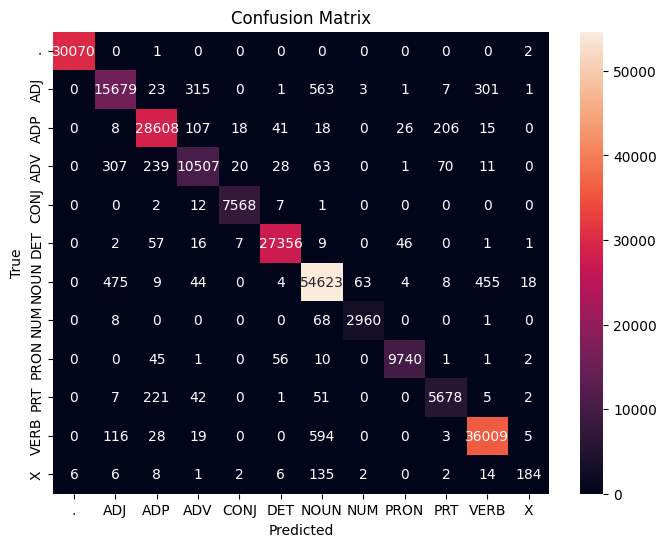

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_ls[0], annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
print(labels)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [16]:
precision_per_pos = []
recall_per_pos = []
f1_score_per_pos = []
f_half_score_per_pos = []
f2_score_per_pos = []
cm = confusion_matrix_ls[0]
for i, tag in enumerate(labels):
    # True Positives (TP)
    TP = cm[i, i]
    
    # False Positives (FP) - sum of column i minus the diagonal element (TP)
    FP = np.sum(cm[:, i]) - TP
    
    # False Negatives (FN) - sum of row i minus the diagonal element (TP)
    FN = np.sum(cm[i, :]) - TP
    
    # Calculate precision and recall
    tag_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    tag_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    tag_f1_score = f_measure(tag_precision, tag_recall, 1)
    tag_f_half_score = f_measure(tag_precision, tag_recall, 0.5)
    tag_f2_score = f_measure(tag_precision, tag_recall, 2)
    
    precision_per_pos.append(tag_precision)
    recall_per_pos.append(tag_recall)
    f1_score_per_pos.append(tag_f1_score)
    f2_score_per_pos.append(tag_f2_score)
    f_half_score_per_pos.append(tag_f_half_score)
    
df_per_pos = {
    "POS": labels,
    "Recall": recall_per_pos,
    "Precision": precision_per_pos,
    "F1 Score": f1_score_per_pos,
    "F2_Score": f2_score_per_pos,
    "F 0.5 Score": f_half_score_per_pos
}

In [19]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print(pd.DataFrame(df_per_pos))

     POS  Recall  Precision  F1 Score  F2_Score  F 0.5 Score
0      .   1.000      1.000     1.000     1.000        1.000
1    ADJ   0.928      0.944     0.936     0.931        0.941
2    ADP   0.985      0.978     0.982     0.984        0.980
3    ADV   0.934      0.950     0.942     0.937        0.947
4   CONJ   0.997      0.994     0.995     0.996        0.994
5    DET   0.995      0.995     0.995     0.995        0.995
6   NOUN   0.981      0.973     0.977     0.979        0.975
7    NUM   0.975      0.978     0.976     0.975        0.977
8   PRON   0.988      0.992     0.990     0.989        0.991
9    PRT   0.945      0.950     0.948     0.946        0.949
10  VERB   0.979      0.978     0.979     0.979        0.978
11     X   0.503      0.856     0.633     0.548        0.750
